## CAPP 30254
## Katy Koenig

In [1]:
import requests
import pandas as pd
import numpy as np
import plotnine as p9
import geopandas as gpd
from shapely.geometry import shape, Point

# Problem 1: Data Acquisition and Analysis

## Step 1: Download Crime Data from City of Chicago Data Portal

In [2]:
os = 0
params = {'$limit': 1000, '$offset': os}
response = requests.get('https://data.cityofchicago.org/resource/6zsd-86xi.json?year=2017', params).json()
total_response = response
os = 1000
while len(response) >= 1000:
    params = {'$limit': 1000, '$offset': os}
    response = requests.get('https://data.cityofchicago.org/resource/6zsd-86xi.json?year=2017', params).json()
    os += 1000
    total_response += response
os = 0
params = {'$limit': 1000, '$offset': os}
response = requests.get('https://data.cityofchicago.org/resource/6zsd-86xi.json?year=2018', params).json()
total_response += response
os = 1000
while len(response) >= 1000:
    params = {'$limit': 1000, '$offset': os}
    response = requests.get('https://data.cityofchicago.org/resource/6zsd-86xi.json?year=2018', params).json()
    os += 1000
    total_response += response

In [3]:
crime_df = pd.DataFrame.from_dict(total_response)

The code below is necessary to convert lat/long from strings for use later in code (for spatial join).

In [4]:
crime_df['longitude'] = crime_df['longitude'].astype(float)
crime_df['latitude'] = crime_df['latitude'].astype(float)

I downloaded this data from the City of Chicago portal to get the names of each community area. 

In [5]:
response = requests.get('https://data.cityofchicago.org/resource/igwz-8jzy.json').json()
comm_area_name_df = pd.DataFrame.from_dict(response)
comm_area_name_df['community_area'] = comm_area_name_df['area_num_1']

Please note that in joining the two dataframes, the few observations where community area was listed as 0 were dropped as this does not correlate to a recognized community area in Chicago.

In [6]:
joined_df = pd.merge(crime_df, comm_area_name_df[['community_area','community']], on=['community_area'])

## Step 2: Summary Statistics & Analysis

The code below produces the difference in types of crimes by year.

In [7]:
year_comparison_df = joined_df.groupby('year')['primary_type'].value_counts().unstack().transpose().reset_index()

In [8]:
year_comparison_df['difference'] = year_comparison_df['2018'] - year_comparison_df['2017']

In [9]:
year_comparison_df

year,primary_type,2017,2018,difference
0,ARSON,432,378,-54
1,ASSAULT,19209,20147,938
2,BATTERY,48914,49350,436
3,BURGLARY,12876,11647,-1229
4,CONCEALED CARRY LICENSE VIOLATION,64,142,78
5,CRIM SEXUAL ASSAULT,1764,1762,-2
6,CRIMINAL DAMAGE,28523,27678,-845
7,CRIMINAL TRESPASS,6744,6818,74
8,DECEPTIVE PRACTICE,19622,19373,-249
9,GAMBLING,191,188,-3


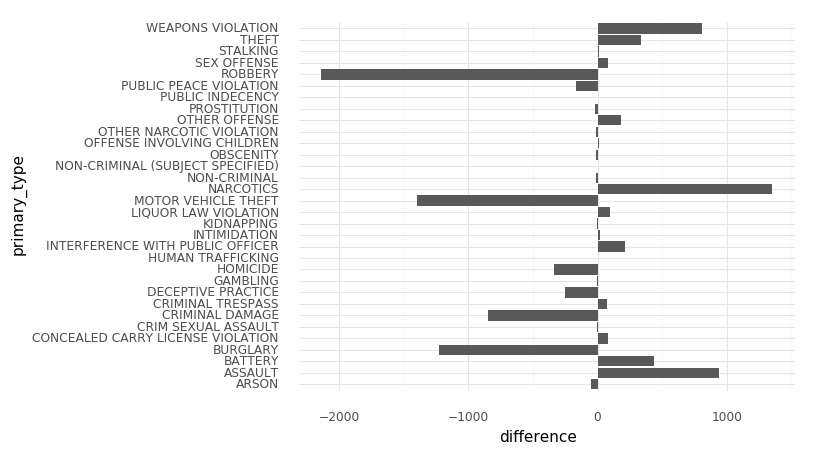

<ggplot: (7617045687)>

In [10]:
p9.ggplot(data=year_comparison_df, mapping=p9.aes('primary_type', 'difference')) + p9.geom_bar(stat='identity') + p9.theme_minimal() + p9.coord_flip()

In [11]:
total_difference = year_comparison_df['difference'].sum()

In [12]:
total_difference

-1826

In [13]:
total_difference/year_comparison_df['2017'].sum()

-0.006810967672148513

As we can see above, crime decreases in absolute value by 1,826 units from 2017 to 2018 or 0.6%.

The code below is used to analyze the differencese across areas of the city.

In [14]:
comm_by_year = joined_df.groupby(['community', 'community_area'])['year'].value_counts().unstack().reset_index()

In [15]:
comm_by_year

year,community,community_area,2017,2018
0,ALBANY PARK,14,2483,2423
1,ARCHER HEIGHTS,57,859,802
2,ARMOUR SQUARE,34,1002,1010
3,ASHBURN,70,2493,2411
4,AUBURN GRESHAM,71,7467,7293
5,AUSTIN,25,15437,15059
6,AVALON PARK,45,1292,1186
7,AVONDALE,21,2347,2287
8,BELMONT CRAGIN,19,4639,4284
9,BEVERLY,72,908,887


Median Crime for Community Areas for 2017

In [16]:
comm_by_year['2017'].median()

2483.0

Median Crime for Community Areas for 2018

In [17]:
comm_by_year['2018'].median()

2394.0

Mean Crime for Community Areas for 2017

In [18]:
comm_by_year['2017'].mean()

3481.779220779221

Mean Crime for Community Areas for 2018

In [19]:
comm_by_year['2018'].mean()

3458.064935064935

As we see above, for both 2017 and 2018, the mean crime rate is higher than the median, meaning that our data is positively-skewed. This would suggest that we have a few areas with very high levels of crime in comparison with the majority of our community areas concentrated towards the left of our distribution curve.

In [20]:
melted_df = pd.melt(comm_by_year, id_vars=['community', 'community_area'])

In [21]:
melted_df

,community,community_area,year,value
0,ALBANY PARK,14,2017,2483
1,ARCHER HEIGHTS,57,2017,859
2,ARMOUR SQUARE,34,2017,1002
3,ASHBURN,70,2017,2493
4,AUBURN GRESHAM,71,2017,7467
5,AUSTIN,25,2017,15437
6,AVALON PARK,45,2017,1292
7,AVONDALE,21,2017,2347
8,BELMONT CRAGIN,19,2017,4639
9,BEVERLY,72,2017,908


The below chart comparies the total crime in each community area for 2017 and 2018.

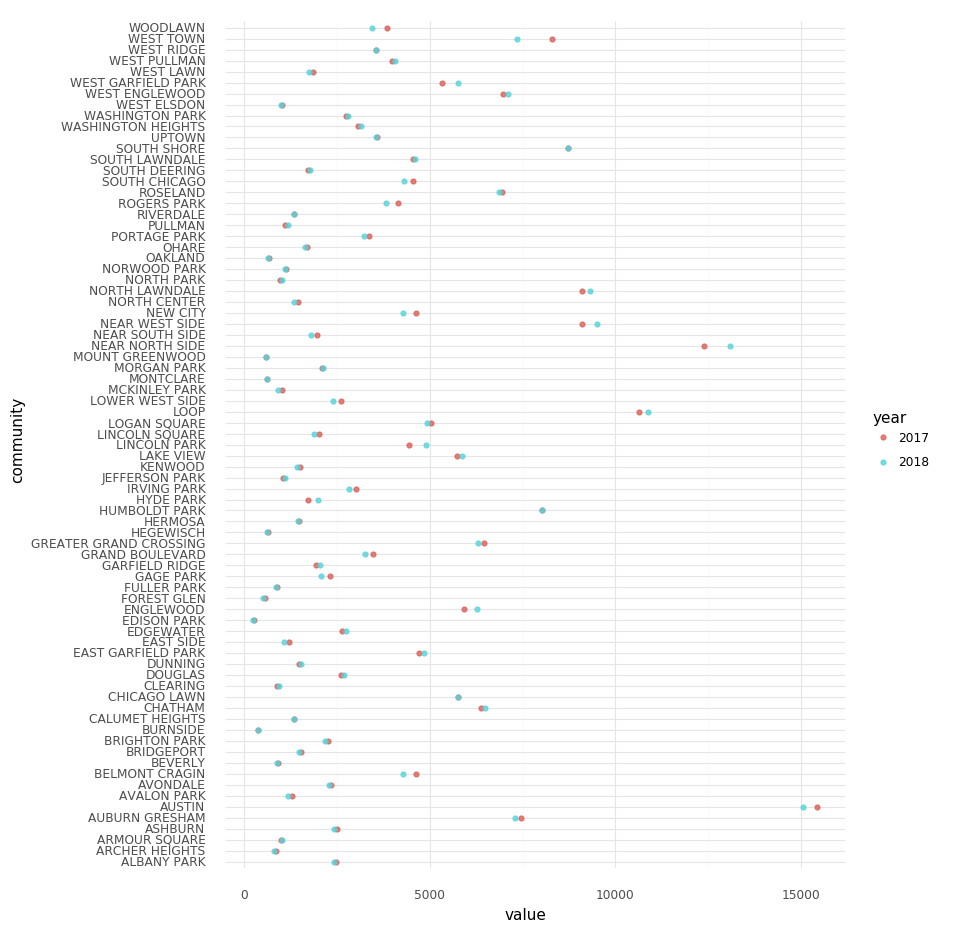

<ggplot: (-9223372029237619638)>

In [22]:
p9.ggplot(melted_df, p9.aes('community', 'value', col='year')) + p9.geom_point(p9.aes(color = 'year'), alpha=0.8) + p9.theme_minimal() + p9.coord_flip() + p9.theme(figure_size=(8, 11))

In [23]:
comm_comparison_df = joined_df.groupby(['community', 'community_area', 'year'])['primary_type'].value_counts().unstack(fill_value=0)
comm_comparison_df

primary_type                            ARSON  ASSAULT  BATTERY  BURGLARY  \
community          community_area year                                      
ALBANY PARK        14             2017      4      125      415       147   
                                  2018      0      147      499       142   
ARCHER HEIGHTS     57             2017      0       52      128        93   
                                  2018      3       52      131        63   
ARMOUR SQUARE      34             2017      0       74      181        52   
                                  2018      0       74      189        39   
ASHBURN            70             2017      3      168      453       189   
                                  2018      3      199      474       135   
AUBURN GRESHAM     71             2017     10      701     1661       337   
                                  2018      9      736     1630       302   
AUSTIN             25             2017     22     1196     3341       509   
                                  2018     42     1248     3285       496   
AVALON PARK        45             2017      5      117      285        76   
                                  2018      2      107      250        64   
AVONDALE           21             2017      8      132      355       137   
                                  2018      6      156      342       151   
BELMONT CRAGIN     19             2017     13      331      852       329   
                                  2018     13      331      899       269   
BEVERLY            72             2017      0       64       97        60   
                                  2018      2       59      106        55   
BRIDGEPORT         60             2017      6      107      222       130   
                                  2018      2      109      236       120   
BRIGHTON PARK      58             2017     11      180      481       125   
                                  2018      7      182      442        97   
BURNSIDE           47             2017      1       36       83        28   
                                  2018      0       37       54        18   
CALUMET HEIGHTS    48             2017      2      109      223        83   
                                  2018      1      132      289        61   
CHATHAM            44             2017      7      532     1261       326   
                                  2018     11      553     1338       270   
...                                       ...      ...      ...       ...   
SOUTH CHICAGO      46             2017     15      409     1078       246   
                                  2018      7      431     1022       255   
SOUTH DEERING      51             2017      3      169      346        67   
                                  2018      2      152      366        54   
SOUTH LAWNDALE     30             2017     11      399      952       188   
                                  2018      9      375      987       169   
SOUTH SHORE        43             2017     10      775     2138       566   
                                  2018      7      784     1983       495   
UPTOWN             3              2017      1      272      662       152   
                                  2018      4      260      648       185   
WASHINGTON HEIGHTS 73             2017      5      216      596       190   
                                  2018      2      242      585       170   
WASHINGTON PARK    40             2017      4      256      722       136   
                                  2018      2      286      688        82   
WEST ELSDON        62             2017      2       50      141        92   
                                  2018      0       57      144       110   
WEST ENGLEWOOD     67             2017     16      591     1614       312   
                                  2018     15      702     1615       277   
WEST GARFIELD PARK 26             2017     10      411     1116       132

Find Most Prevalent Crime by Neighborhood for 2017 and 2018

In [24]:
comm_comparison_df.idxmax(axis=1)

community           community_area  year
ALBANY PARK         14              2017      THEFT
                                    2018      THEFT
ARCHER HEIGHTS      57              2017      THEFT
                                    2018      THEFT
ARMOUR SQUARE       34              2017      THEFT
                                    2018      THEFT
ASHBURN             70              2017      THEFT
                                    2018      THEFT
AUBURN GRESHAM      71              2017    BATTERY
                                    2018    BATTERY
AUSTIN              25              2017    BATTERY
                                    2018    BATTERY
AVALON PARK         45              2017    BATTERY
                                    2018    BATTERY
AVONDALE            21              2017      THEFT
                                    2018      THEFT
BELMONT CRAGIN      19              2017      THEFT
                                    2018    BATTERY
BEVERLY             72 

In [25]:
most_common_crimes = comm_comparison_df.idxmax(axis=1).unique()
comm_crimes_df = comm_comparison_df[most_common_crimes].reset_index()
comm_crimes_df

primary_type,community,community_area,year,THEFT,BATTERY,NARCOTICS
0,ALBANY PARK,14,2017,689,415,26
1,ALBANY PARK,14,2018,580,499,27
2,ARCHER HEIGHTS,57,2017,177,128,19
3,ARCHER HEIGHTS,57,2018,199,131,23
4,ARMOUR SQUARE,34,2017,261,181,8
5,ARMOUR SQUARE,34,2018,318,189,12
6,ASHBURN,70,2017,477,453,34
7,ASHBURN,70,2018,487,474,46
8,AUBURN GRESHAM,71,2017,1197,1661,336
9,AUBURN GRESHAM,71,2018,1118,1630,397


The printed charts below show the amount of each of the 3 top crimes (theft, battery, narcotics) for each community area in 2017 and 2018.

In [107]:
for crime in most_common_crimes:
    print(crime)
    print(comm_comparison_df[crime])
    print()

THEFT
community           community_area  year
ALBANY PARK         14              2017     689
                                    2018     580
ARCHER HEIGHTS      57              2017     177
                                    2018     199
ARMOUR SQUARE       34              2017     261
                                    2018     318
ASHBURN             70              2017     477
                                    2018     487
AUBURN GRESHAM      71              2017    1197
                                    2018    1118
AUSTIN              25              2017    2145
                                    2018    2278
AVALON PARK         45              2017     245
                                    2018     216
AVONDALE            21              2017     668
                                    2018     633
BELMONT CRAGIN      19              2017     861
                                    2018     737
BEVERLY             72              2017     238
                      

In the following analysis, I slotted each of the 77 community areas in their respective "sides" of the city (Central, North, South, West). Because Chicago is very divided along these lines in terms of race, income, resources, etc., it seemed significant to analyze this difference with respect to crime as well.

For the zones/demarcation I used in this analysis of North/Central/South/West sides: https://www.kaggle.com/mcnutt/chicagocommunityareas

In [27]:
sides_df = pd.read_csv('community-areas.csv').drop(columns = 'Unnamed: 2')
sides_df['community_area'] = sides_df['id']
sides_df = sides_df.astype(str)

In [28]:
comm_w_sides = pd.merge(comm_comparison_df.reset_index(), sides_df[['community_area', 'zone']], on=['community_area'])

The below chart compares narcotics arrests between the four zones.

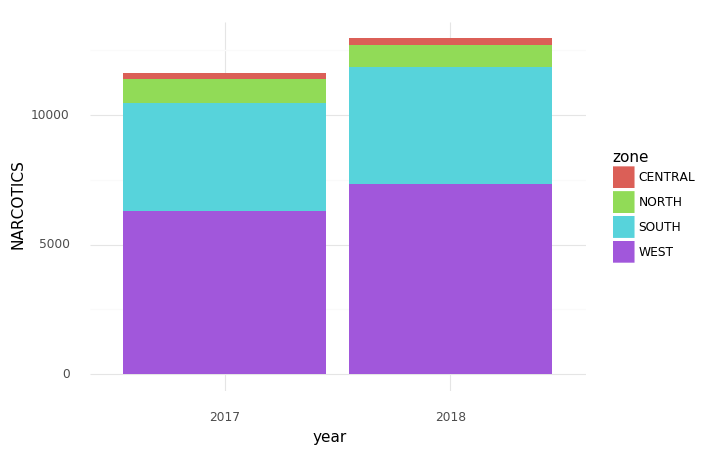

<ggplot: (-9223372029236462255)>

In [29]:
p9.ggplot(data = comm_w_sides, mapping=p9.aes('year','NARCOTICS', fill = 'zone')) + p9.geom_col() + p9.theme_minimal()

The below chart compares battery arrests between the four zones.

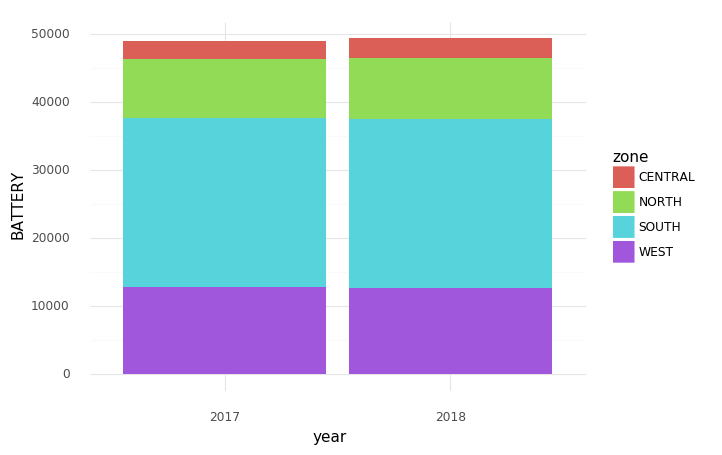

<ggplot: (-9223372029236528149)>

In [30]:
p9.ggplot(data = comm_w_sides, mapping=p9.aes('year','BATTERY', fill = 'zone')) + p9.geom_col() + p9.theme_minimal()

The below chart compares theft arrests between the four zones.

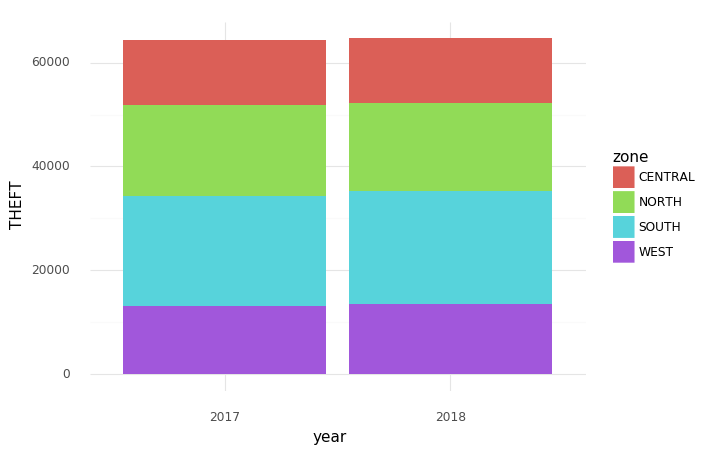

<ggplot: (7618247579)>

In [31]:
p9.ggplot(data = comm_w_sides, mapping=p9.aes('year','THEFT', fill = 'zone')) + p9.geom_col() + p9.theme_minimal()

From the above charts, we can see that while thefts remain somewhat stagnant and relatively evenly divided in each zone from 2017 to 2018, narcotics arrests increased specifically in the West side from 2017 to 2018. We can also note that while we see the most battery arrests in the South side, we see the most narcotics arrests in the West side for both 2017 and 2018.

# Problem 2: Data Augmentation and APIs

Please note that as zipcode data was unavailable from the American Community Survey data, census tract data was used for this analysis instead.

In [32]:
response = requests.get('https://api.census.gov/data/2017/acs/acs5?get=B19001_002E,B19001_003E,B19001_004E,B19001_005E,B02001_001E,B02001_002E,B02001_003E,B03002_012E,B15003_017E,B15003_022E,NAME&for=tract:*&in=state:17%20county:031').json()

In [33]:
census_df = pd.DataFrame.from_dict(response)

In [34]:
census_df.columns = census_df.iloc[0]

In [35]:
census_df = census_df[1:]

In [36]:
cols = ['B19001_002E', 'B19001_003E', 'B19001_004E', 'B19001_004E', 'B19001_005E']
census_df[cols] = census_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [37]:
census_df['total_below_pov_line'] = census_df['B19001_002E'] + census_df['B19001_003E'] + census_df['B19001_004E'] + census_df['B19001_004E'] + census_df['B19001_005E']

In [38]:
census_df.drop(columns=['B19001_002E', 'B19001_003E', 'B19001_004E', 'B19001_004E', 'B19001_005E'], inplace=True)

In [39]:
census_df.rename(index=str, columns={"B02001_001E": "total_pop", "B02001_002E": "white_pop", "B02001_003E": "black_pop", "B03002_012E": "hispanic_pop", "B15003_017E": "high_school_degree", "B15003_022E": "bachelors_degree"}, inplace=True)

The below code collects the census tract boundaries for Chicago tracts from City of Chicago data portal through API.

In [40]:
r = requests.get('https://data.cityofchicago.org/resource/74p9-q2aq.json')

In [41]:
tract_data = r.json()

In [42]:
for d in tract_data:
    d['geometry'] = shape(d['the_geom'])

In [43]:
tracts_gdf = gpd.GeoDataFrame(tract_data).set_geometry('geometry')

In [44]:
tracts_gdf['tract'] = tracts_gdf['tractce10']

In [45]:
pd.to_numeric(tracts_gdf['tract'])

0      842400
1      840300
2      841100
3      841200
4      839000
5      838200
6      650301
7      530503
8      760803
9       30601
10      30604
11      20801
12     540102
13     843300
14     540101
15     440201
16      80202
17      70102
18      31501
19      31502
20     834900
21     834800
22     160502
23     140702
24     842000
25     150402
26     834400
27      40201
28      40202
29      20702
        ...  
771    291200
772    620300
773    620400
774    630100
775    630300
776    630400
777    630500
778    110300
779    110400
780    280100
781    120100
782    280800
783    120200
784    271400
785     71000
786    281900
787    550100
788     71200
789    611500
790    611800
791    611900
792    612000
793    620100
794    620200
795     70200
796     70400
797     70500
798    130300
799    292200
800    630900
Name: tract, Length: 801, dtype: int64

In [46]:
census_w_tracts = pd.merge(census_df, tracts_gdf[['tract','geometry']], on=['tract'], how='inner')

In [47]:
census_tracts_gdf = gpd.GeoDataFrame(census_w_tracts, geometry='geometry')

I dropped the null values for lat/long as I could not convert them into Point objects for geopandas use.

In [48]:
crime_df = crime_df[crime_df['latitude'].notnull()]

In [49]:
crime_df

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,...,latitude,location,location_description,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year
0,False,0832,067XX S ARTESIAN AVE,JA504564,66,2017-11-08T20:50:00.000,DOMESTIC BATTERY SIMPLE,008,True,08B,...,41.771504,"{'type': 'Point', 'coordinates': [-87.68465075...",STREET,-87.684651,BATTERY,2019-04-07T15:58:05.000,17,1161200,1859994,2017
1,False,1023,012XX S FAIRFIELD AVE,JA235850,29,2017-04-23T10:28:00.000,SEX ASSLT OF CHILD BY FAM MBR,010,True,02,...,41.865123,"{'type': 'Point', 'coordinates': [-87.69460150...",RESIDENCE,-87.694602,OFFENSE INVOLVING CHILDREN,2019-04-07T15:58:05.000,28,1158232,1894088,2017
5,False,1655,0000X W TERMINAL ST,JA552928,76,2017-12-16T14:30:00.000,$500 AND UNDER,016,False,06,...,41.974862,"{'type': 'Point', 'coordinates': [-87.89037215...",AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA,-87.890372,THEFT,2019-04-05T16:07:16.000,41,1104700,1933741,2017
11,False,0523,126XX S EMERALD AVE,JA330857,53,2017-07-01T16:00:00.000,CRIM SEX ABUSE BY FAM MEMBER,005,True,17,...,41.664518,"{'type': 'Point', 'coordinates': [-87.64026354...",RESIDENCE,-87.640264,OFFENSE INVOLVING CHILDREN,2019-04-04T16:07:03.000,34,1173622,1821104,2017
12,False,0522,002XX W 112TH ST,JA317004,49,2017-06-20T02:00:00.000,CRIM SEX ABUSE BY FAM MEMBER,005,True,17,...,41.690697,"{'type': 'Point', 'coordinates': [-87.62907195...",RESIDENCE,-87.629072,OFFENSE INVOLVING CHILDREN,2019-04-04T16:07:03.000,34,1176602,1830668,2017
13,False,0614,086XX S BISHOP ST,JA176893,71,2017-03-05T22:00:00.000,AGG CRIM SEX ABUSE FAM MEMBER,006,True,17,...,41.736989,"{'type': 'Point', 'coordinates': [-87.65944964...",RESIDENCE,-87.659450,OFFENSE INVOLVING CHILDREN,2019-04-04T16:07:03.000,21,1168173,1847470,2017
19,True,0312,064XX S CHAMPLAIN AVE,JA407726,42,2017-08-27T05:25:00.000,FIRST DEGREE MURDER,003,False,01A,...,41.777853,"{'type': 'Point', 'coordinates': [-87.60952399...",STREET,-87.609524,HOMICIDE,2019-04-03T16:04:24.000,20,1181674,1862471,2017
21,False,1231,018XX W TAYLOR ST,JA548532,28,2017-12-07T00:01:00.000,AGGRAVATED: OTHER,012,False,02,...,41.869185,"{'type': 'Point', 'coordinates': [-87.67198888...",NURSING HOME/RETIREMENT HOME,-87.671989,CRIM SEXUAL ASSAULT,2019-04-03T16:04:24.000,27,1164380,1895615,2017
24,False,0524,122XX S PEORIA ST,JA531665,53,2017-11-30T19:40:00.000,AGGRAVATED,005,True,09,...,41.671773,"{'type': 'Point', 'coordinates': [-87.64414609...",STREET,-87.644146,ARSON,2019-04-01T16:11:25.000,34,1172540,1823739,2017
25,False,0623,076XX S VINCENNES AVE,JA297695,69,2017-06-04T11:00:00.000,NON-AGGRAVATED,006,True,02,...,41.756092,"{'type': 'Point', 'coordinates': [-87.63234133...",RESTAURANT,-87.632341,CRIM SEXUAL ASSAULT,2019-04-01T16:11:25.000,17,1175515,1854490,2017


In [50]:
crime_df['geometry'] = list(zip(crime_df.longitude, crime_df.latitude))

In [51]:
crime_df['geometry'] = crime_df['geometry'].apply(Point)

In [52]:
points_gdf = gpd.GeoDataFrame(crime_df, geometry='geometry')

In [53]:
augmented_crime_df = gpd.sjoin(points_gdf, census_tracts_gdf, how="left", op='intersects')

In [90]:
columns = ['total_pop', 'white_pop', 'black_pop', 'hispanic_pop', 'high_school_degree', 'bachelors_degree', 'total_below_pov_line']

In [91]:
augmented_crime_df[columns] = augmented_crime_df[columns].apply(pd.to_numeric, errors='coerce')

## Steps 1 & 2

The code below finds the top 10 census tracts with highest rates a specific crime (battery or homicide) and the demographic info by percentage.

In [113]:
for p_type in ['BATTERY', 'HOMICIDE']:
    type_mask = augmented_crime_df['primary_type'] == p_type
    high_tracts = augmented_crime_df[type_mask].groupby('tract')['primary_type'].value_counts().sort_values(ascending=False)[:10].unstack().reset_index()
    tract_mask = augmented_crime_df['tract'].isin(list(high_tracts['tract']))
    grouped_df = augmented_crime_df[tract_mask].groupby('tract')[columns].sum()
    percentage_df = grouped_df[['white_pop', 'black_pop', 'hispanic_pop', 'high_school_degree', 'bachelors_degree', 'total_below_pov_line']].div(grouped_df['total_pop'].values,axis=0)
    over_top_tracts_df = percentage_df.mean()
    print(p_type)
    print('Ind. Demographic Data of Top 10 Tracts')
    print(percentage_df.reset_index())
    print()
    print('Demographic Data Mean of Top 10 Tracts')
    print(over_top_tracts_df)
    print()
    print()

BATTERY
Ind. Demographic Data of Top 10 Tracts
    tract  white_pop  black_pop  hispanic_pop  high_school_degree  \
0  231200   0.079831   0.523135      0.435973            0.107364   
1  231500   0.029557   0.874310      0.103150            0.217943   
2  251800   0.070900   0.915829      0.032607            0.184645   
3  251900   0.018305   0.942205      0.037433            0.147882   
4  252202   0.026067   0.973933      0.012193            0.162708   
5  420700   0.037626   0.931478      0.010095            0.118691   
6  431302   0.013458   0.976208      0.017784            0.167748   
7  440101   0.015672   0.928109      0.028109            0.168159   
8  838700   0.038221   0.924638      0.057655            0.123947   
9  839100   0.575000   0.139645      0.101036            0.040237   

   bachelors_degree  total_below_pov_line  
0          0.046106              0.175627  
1          0.017764              0.126138  
2          0.025024              0.207962  
3          0.0244

To Find Average Demographic Info Across Chicago Census Tracts for Comparison with Above Statistics:

In [105]:
totaled_df = augmented_crime_df[columns].sum()
totaled_df.div(totaled_df['total_pop'])

total_pop               1.000000
white_pop               0.400625
black_pop               0.418208
hispanic_pop            0.220688
high_school_degree      0.130538
bachelors_degree        0.151235
total_below_pov_line    0.136760
dtype: float64

2.1 Answer: As we can see through comparison of the total mean demographic info and the demographic data for the census tracts with high battery arrests, we can see that on average, the census tracts with higher battery rates are portionally less white (~9% pop. in high battery areas compared to 40% overall) and less hispanic (~8% pop. in high battery areas compared to ~22% overall) and more black (~81% pop. in high battery areas compared to ~42% overall). Furthermore, while the population in high battery census tracts exhibits slightly higher rates of high school education at ~14% of the population as compared to ~13% in the overall population, those in high battery census tracts are much less likely to have a bachelor's degree (~6% of those in high battery areas have a bachelor's degree as compared to ~15% in the overall Chicago population. Additionally, populations living in areas where there is a high incidence of battery are more likely to be below the poverty line (as defined here as earning less than $20,000/year) than the average Chicagoan at large.

2.2 Answer: From the tables above, we can see that in areas where there are high incidents of homicides, like with battery, there is a low percentage of white (~4%) and hispanic occupants (~6%) and a high percentage of black residents (92%) as compared to the overal Chicago population (white: ~40%; hispanic: ~22%; black: ~42%). Similarly, in these areas, the population is more likely to have a high school diploma (~18%) than the overall average (~13%) and less likely to have a bachelor's degree (~4% compared to ~15% overall). Again, the poverty rate is higher in areas with higher rates of homicide (~21%) than throughout all of the city (~14%). 

## Step 3

In [269]:
for p_type in ['BATTERY', 'HOMICIDE']:
    type_mask = augmented_crime_df['primary_type'] == p_type
    high_tracts = augmented_crime_df[type_mask].groupby(['year', 'tract'])['primary_type'].value_counts().sort_values(ascending=False)[:10].unstack().reset_index()
    mask = augmented_crime_df['tract'].isin(list(high_tracts['tract']))
    grouped_df = augmented_crime_df[mask].groupby(['tract', 'year'])[columns].sum()
    top_tracts_df = grouped_df.groupby('year').sum().apply(lambda x: x/grouped_df.groupby('year')['total_pop'].sum())
    print(p_type)
    print('Ind. Data Mean of Top 10 Tracts')
    print(grouped_df)
    print()
    print('Demographic Data Mean of Top 10 Tracts')
    print(top_tracts_df)
    print()

BATTERY
Ind. Data Mean of Top 10 Tracts
              total_pop   white_pop   black_pop  hispanic_pop  \
tract  year                                                     
231500 2017   9867627.0    291654.0   8627361.0     1017843.0   
       2018  12091695.0    357390.0  10571885.0     1247255.0   
251900 2017   5430854.0     99413.0   5116977.0      203294.0   
       2018   5377372.0     98434.0   5066586.0      201292.0   
420700 2017   3622052.0    136284.0   3373860.0       36564.0   
       2018   3435719.0    129273.0   3200295.0       34683.0   
440101 2017   4068240.0     63756.0   3775772.0      114356.0   
       2018   4100400.0     64260.0   3805620.0      115260.0   
838700 2017   6668640.0    254880.0   6166080.0      384480.0   
       2018   6631592.0    253464.0   6131824.0      382344.0   
839100 2017  29784560.0  17126122.0   4159264.0     3009298.0   
       2018  33191600.0  19085170.0   4635040.0     3353530.0   

             high_school_degree  bachelors_degree

2.3 Answer: For the census tracts with high battery rates, from 2017 to 2018, we see very little change. Most notably, the overall black population in areas with high battery rates has decreased by 1% while the percentage below the poverty line in these areas has decreased by roughly 0.5%. For census tracts with high homicide rates, from 2017 to 2018, the white population decreased by ~0.3% and the percentage betlow the povery line decreased by ~0.4% while there has been little change in black population, hispanic population, those with bachelor's degrees and those with high school diplomas in these tracts.

## Step 4

The code below finds the top 10 census tracts with highest rates a specific crime (deceptive practice & sex offense) and the demographic info by percentage.

In [117]:
for p_type in ['DECEPTIVE PRACTICE', 'SEX OFFENSE']:
    type_mask = augmented_crime_df['primary_type'] == p_type
    high_tracts = augmented_crime_df[type_mask].groupby('tract')['primary_type'].value_counts().sort_values(ascending=False)[:10].unstack().reset_index()
    tract_mask = augmented_crime_df['tract'].isin(list(high_tracts['tract']))
    grouped_df = augmented_crime_df[tract_mask].groupby('tract')[columns].sum()
    percentage_df = grouped_df[['white_pop', 'black_pop', 'hispanic_pop', 'high_school_degree', 'bachelors_degree', 'total_below_pov_line']].div(grouped_df['total_pop'].values,axis=0)
    over_top_tracts_df = percentage_df.mean()
    print(p_type)
    print('Ind. Demographic Data of Top 10 Tracts')
    print(percentage_df.reset_index())
    print()
    print('Demographic Data Mean of Top 10 Tracts')
    print(over_top_tracts_df)
    print()
    print()

DECEPTIVE PRACTICE
Ind. Demographic Data of Top 10 Tracts
    tract  white_pop  black_pop  hispanic_pop  high_school_degree  \
0  081201   0.833548   0.025129      0.074313            0.026418   
1  081403   0.738572   0.033661      0.038114            0.035625   
2  081500   0.707249   0.025230      0.070485            0.055467   
3  081700   0.765414   0.023803      0.052767            0.005736   
4  320100   0.773923   0.051966      0.058796            0.042625   
5  320400   0.682033   0.093780      0.057783            0.007262   
6  330100   0.500500   0.225717      0.061110            0.040862   
7  839100   0.575000   0.139645      0.101036            0.040237   
8  841900   0.552005   0.173452      0.137656            0.039791   
9  980000        NaN        NaN           NaN                 NaN   

   bachelors_degree  total_below_pov_line  
0          0.315292              0.062500  
1          0.348134              0.103078  
2          0.385062              0.143172  
3     

2.4 Answer: As we can see in the tables above, census tracts that (while there are not many census tracts where this occurs), those that have high incidences of deceptive practice tend to be white (~68%), more highly educated (~29% population have bachelor's degrees) and less likely to be below the poverty line (~8%) than the overall population of Chicago. In census tracts where there are high incidents of sex offences, the population is more white than average (~55% vs. ~40%), more hispanic than average (~34% vs. ~22%) and less likely to be below the poverty line than the overall Chicago population (~10% vs. ~14%).

# Problem 3: Analysis and Communication

3.1 Answer: Overall, crime has decreased slightly from 2017 to 2018 (roughly 0.6%). The most common crime in each Chicago neighborhood battery, theft or narcotics, and the frequency of these battery and theft throughout the city did not drastically change, while narcotics actually increased, particularly in the West side of Chicago. Furthermore, demographics of areas with high rates of homicide and battery did not change drastically from 2017 to 2018.

In [288]:
crime_df['use_date'] = pd.to_datetime(crime_df['date'])
jul_2017_mask = (crime_df['use_date'] >= '2017-06-28') & (crime_df['use_date'] < '2017-07-26')
jul_2018_mask = (crime_df['use_date'] >= '2018-06-28') & (crime_df['use_date'] < '2018-07-26')

In [340]:
cand_crime_lst = ['ROBBERY', 'BATTERY', 'BURGLARY', 'MOTOR VEHICLE THEFT']
for crime in cand_crime_lst:
    num_crime_2017 = crime_df[jul_2017_mask & (crime_df['primary_type'] == crime)].shape[0]
    num_crime_2018 = crime_df[jul_2018_mask & (crime_df['primary_type'] == crime)].shape[0]
    print(crime)
    print(100* (num_crime_2018 - num_crime_2017) / num_crime_2017)

ROBBERY
-11.293859649122806
BATTERY
6.798935398015969
BURGLARY
-9.099181073703367
MOTOR VEHICLE THEFT
-18.281938325991188


To check if any "aggravated batteries" during time period:

In [339]:
    num_agg_batt_2017 = crime_df[jul_2017_mask & (crime_df['primary_type'] == 'BATTERY') & (crime_df['description'] == 'AGGRAVATED')].shape[0]
    num_agg_batt_2018 = crime_df[jul_2018_mask & (crime_df['primary_type'] == "BATTERY") & (crime_df['description'] == 'AGGRAVATED')].shape[0]
    print(num_agg_batt_2017)
    print(num_agg_batt_2018)

0
0


3.2.A No, these statistics are incorrect. While robbery, motor vehicle theft, burglary have decreased (~11%, ~18%, ~9%, respectively) from 2017 to 2018, battery (of all types because there were no "aggravated batteries" in the dataset) increased by only ~7% for the time period 6/28 to 7/28 from 2017 to 2018. As noted, at the beginning of this analysis, crime overall decreased by ~0.6% from 2017 to 2018.

3.2.B Answer: These statistics could definitely be misleading, beginning with what looks like a comparison of time periods mentioned here: from 6-28-2018 to 07-28-2018 compared to 07-21-17 to 07-28-18. This may be a typo/mispoken, but it would be incredibly incorrect to compare a month's worth of crimes to a week's worth of crimes. Furthermore, even if the candidate is referring to a specific 28-day period (i.e. assuming the "week" in the phrase is typo), this could still be misleading (even if the statistics were true). The aldermanic candidate's team could have singled out the highest crime month of the year to dramatize the issue. Also, the wording regarding seeing "how crime has affected our local neighborhoods in a four-year period" and proceeding to state that crime rose 10% since 2017 (1) does not make sense (four-year period compared to the 1.25 years that has passed since 2017 ended) and (2) is not true in that the data shows that crime has decreased slightly in the past year.

3.3 Answer: My key findings would be:

(1) Crime in Chicago is going down, albeit at what seems like a slow rate but it is important to note that even at 0.6%, there were 1800+ fewer crimes in 2018, which is not neglibable. This fact should be promoted as we heard so much media to the contrary regarding safety in Chicago.

(2) Crime is localized. It does not affect every community in Chicago equally. There are areas that experience high rates of crime and those that experience much lower rates of crime. It is vital in crafting policies to focus on these localized communities and not the city overall as this is a question (like so many in Chicago) of equity and segregation.

(3) Similarly, types of crimes vary drastically from census tract to census tract (and their subsequent demographics). Therefore, we cannot treat crime as a monolith and attempt to lower the crime rate by applying the same policies across the city. Instead, we must craft policies that address specific crimes/areas.
(4) Demographic information of areas with certain amount of crime does not vary drastically from year to year. This may reflect that policies attempting to lower the crime rate should not just focus on "law and order," but instead it may be useful/necessary to direct attention to social issues like education and income to address crime.

(5) While crime overall decreased, the three "top" crimes (theft, narcotics, battery) either remained steady or increased from 2017 to 2018. While this means that more "obscure" crimes decreased, it also means that policies to address these issues specifically can be more effective than those targeted generally or at other types of crimes.

3.4 Answer: It is important to note that we only analyzed crime over a two year period. Therefore, we cannot assess any longer term trends in crime. It may be more useful use data over a long period of time to find trends in crime over time or to look at effectiveness of any policy implementation. Furthermore, it is worth noting that we looked only at reported crime and did not differentiate between crimes that resulted in an arrest and crimes that did not as to avoid speculation. Additionally, while some demographic information was used in this analysis, the few variables that were utilized cannot provide a full picture of this complicated issue. Similarly, it is worth noting that this dataset cannot give a 100% accurate description of crime in Chicago as there will is missing data (unreported crimes) and misreported crimes.

In [359]:
mich_ave_crimes = crime_df[crime_df['block'] == '021XX S MICHIGAN AVE']['primary_type'].value_counts().reset_index()

3.a Answer: For a crime on the 2100th block of S. Michigan Ave, the probabilities of each crimes are described in the table below (most notably, there is a 25% probability it is a battery request and a 25% probability will be described as an 'other offense'):

In [361]:
mich_ave_crimes['prob'] = (100*mich_ave_crimes['primary_type'])/mich_ave_crimes['primary_type'].sum()
mich_ave_crimes

,index,primary_type,prob
0,OTHER OFFENSE,15,25.000000
1,BATTERY,15,25.000000
2,ASSAULT,6,10.000000
3,THEFT,5,8.333333
4,DECEPTIVE PRACTICE,5,8.333333
5,MOTOR VEHICLE THEFT,4,6.666667
6,CRIMINAL DAMAGE,4,6.666667
7,PUBLIC PEACE VIOLATION,2,3.333333
8,ROBBERY,2,3.333333
9,BURGLARY,1,1.666667


3.b Answer: There is a 1.53% probability that the theft call is from Uptown and a 1.94% probability that the theft call is from Garfield Park (combining East Garfield Park and West Garfield Park community areas). It is 26.96% more likely that the call is coming from Garfield Park than Uptown.

In [374]:
total_thefts = joined_df[joined_df['primary_type'] == 'THEFT'].shape[0]

In [413]:
thefts_uptown = joined_df[(joined_df['primary_type'] == 'THEFT') & (joined_df['community'] == 'UPTOWN')].shape[0]

In [412]:
thefts_garfield_park = joined_df[(joined_df['primary_type'] == 'THEFT') & (joined_df['community'] == 'EAST GARFIELD PARK')| (joined_df['primary_type'] == 'THEFT') & (joined_df['community'] == 'WEST GARFIELD PARK')].shape[0]

In [411]:
print('Percent of Thefts from Uptown')
print(100*thefts_uptown/total_thefts)
print('Percent of Thefts from Garfield Park')
print(100*thefts_garfield_park/total_thefts)
print("Comparison")
print(100*(thefts_garfield_park - thefts_uptown)/thefts_uptown)

Percent of Thefts from Uptown
1.5275580782233802
Percent of Thefts from Garfield Park
1.9393008901709003
Comparison
26.95431472081218


3.c Answer: We already know that the call is regarding battery and out of the 260 battery calls, 100 are from Garfield Park and 160 are from Uptown. Therefore, if the call is regarding battery, there is a 23.08% less likely that the call is from Uptown than Garfield Park.

((160 - 100)*100)/260 = 23.08